First thing we need to notice is that the original dataset was divided into two regions : Bejaia and SidiBel each containing 122 instances.
Column meanings:
- **Date** : Date of the measurement
- **Temperature** : Temperature in Celsius (22 to 44)
- **RH** : Relative Humidity (21 to 90%)
- **Ws** : Wind speed (6 to 29 km/h)
- **Rain** : Total rain in the day (0 to 16.8 mm)

Then we have the FWI (Fire Weather Index) components. FWI is a classification system that uses the previous columns to determine the risk of fire. 
FWI (Fire Weather Index) column meanings:
- **FFMC** : Fine Fuel Moisture Code (28.6 to 92.5), which measures the moisture of fine combustibles on the forest floor
- **DMC** : Duff Moisture Code (1.1 to 65.9), which measures the moisture in the thickest materials
- **DC** : Drought Code (7.0 to 220.4), which measures the moisture in the soil
- **ISI** : Initial Spread Index (0.0 to 18.5), which measures the inital rate of fire spread
- **BUI** : Build Up Index (1.1 to 68.0), which measure the total amount of fuel available
- **FWI** : Fire Weather Index (0.0 to 31.1), which brings all the previous components together

Finally we have the **Classes** column which is the target variable. It represents wether or not a fire occured in the day.

In [2]:
#Defining Global Variables
DATA_PATH = 'data'
DATA_FILE = 'Algerian_forest_fires_dataset.csv'
DATA_FILE_BEJAIA = 'Bejaia_Region_Dataset.csv'
DATA_FILE_SIDIBEL = 'SidiBel_Region_Dataset.csv'

#Importing Libraries
import pandas as pd

The dataset contains 3 columns `day, month, year` which can be used to create a `Date` column.

It also contains columns with whitespaces in their names, which we will rename.

In [3]:
# read csv file
fire_data = pd.read_csv(f'{DATA_PATH}/{DATA_FILE}')
# create Date column
fire_data['Date'] = pd.to_datetime(fire_data[['day','month','year']].apply(lambda x: '/'.join(x.astype(str)),axis = 1), format='%d/%m/%Y')
# remove day, month and year columns
fire_data.drop(['day','month','year'], axis=1, inplace=True)
print(fire_data.head())

# get columns which have whitespaces in their names
fire_data.columns = fire_data.columns.str.replace(' ', '')
print(fire_data.columns)


   Temperature   RH   Ws  Rain   FFMC  DMC    DC  ISI  BUI  FWI    Classes    \
0           29   57   18    0.0  65.7  3.4   7.6  1.3  3.4  0.5  not fire      
1           29   61   13    1.3  64.4  4.1   7.6  1.0  3.9  0.4  not fire      
2           26   82   22   13.1  47.1  2.5   7.1  0.3  2.7  0.1  not fire      
3           25   89   13    2.5  28.6  1.3   6.9  0.0  1.7    0  not fire      
4           27   77   16    0.0  64.8  3.0  14.2  1.2  3.9  0.5  not fire      

        Date  
0 2012-06-01  
1 2012-06-02  
2 2012-06-03  
3 2012-06-04  
4 2012-06-05  
Index(['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI',
       'FWI', 'Classes', 'Date'],
      dtype='object')


One of the first things to do is to identify if there are any missing values in the dataset. We can do this by using the `isnull()` function.

In [4]:
# check for missing values in the dataset
missing_values = fire_data.isnull() 
# print the rows that contains missing values
print(fire_data[missing_values.any(axis=1)])


     Temperature  RH  Ws  Rain  FFMC   DMC      DC   ISI   BUI      FWI  \
165           37  37  18   0.2  88.9  12.9  14.6 9  12.5  10.4  fire      

    Classes       Date  
165     NaN 2012-07-14  


We can see that the dataset contains one row with missing values. However, it is a delimiter problem. The missing value is actually in the same row as the column names, but instead of a `','` it has a `' '`. We will simply delete it and also check for duplicate instances.

In [5]:
# delete the row that has a missing value
error_rows = fire_data[missing_values.any(axis=1)]
# for each row in error_rows
for index, row in error_rows.iterrows():
    # get the date
    date = row['Date']
    # get the index of the row that has the same date
    index_to_delete = fire_data[fire_data['Date'] == date].index
    # delete the row
    fire_data.drop(index_to_delete, inplace=True)
# check if it was actually deleted
print(fire_data[missing_values.any(axis=1)])

# check for duplicates
fire_data.drop_duplicates(inplace=True)

Empty DataFrame
Columns: [Temperature, RH, Ws, Rain, FFMC, DMC, DC, ISI, BUI, FWI, Classes, Date]
Index: []


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_11760\2337743853.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(fire_data[missing_values.any(axis=1)])


Next, it's always a good idea to look at the distribution of the data. We can do this by using the `describe()` function.

In [6]:
fire_data.describe()

,Temperature,RH,Ws,Rain,FFMC,DMC,ISI,BUI
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,32.144628,62.045455,15.504132,0.763636,77.858678,14.709091,4.756198,16.724793
std,3.633602,14.858740,2.812609,2.007331,14.377130,12.410780,4.157249,14.247864
min,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,0.000000,1.100000
25%,30.000000,52.250000,14.000000,0.000000,71.625000,5.800000,1.400000,6.000000
50%,32.000000,63.000000,15.000000,0.000000,83.500000,11.300000,3.500000,12.450000
75%,35.000000,73.750000,17.000000,0.500000,88.300000,20.850000,7.275000,22.775000
max,42.000000,90.000000,29.000000,16.800000,96.000000,65.900000,19.000000,68.000000


Lets plot the distribution of each columng along the diagonal using scatterplots. Then we can plot a scatterplot matrix for the combination of each variable. It makes an efficient tool to look for errors in the data.

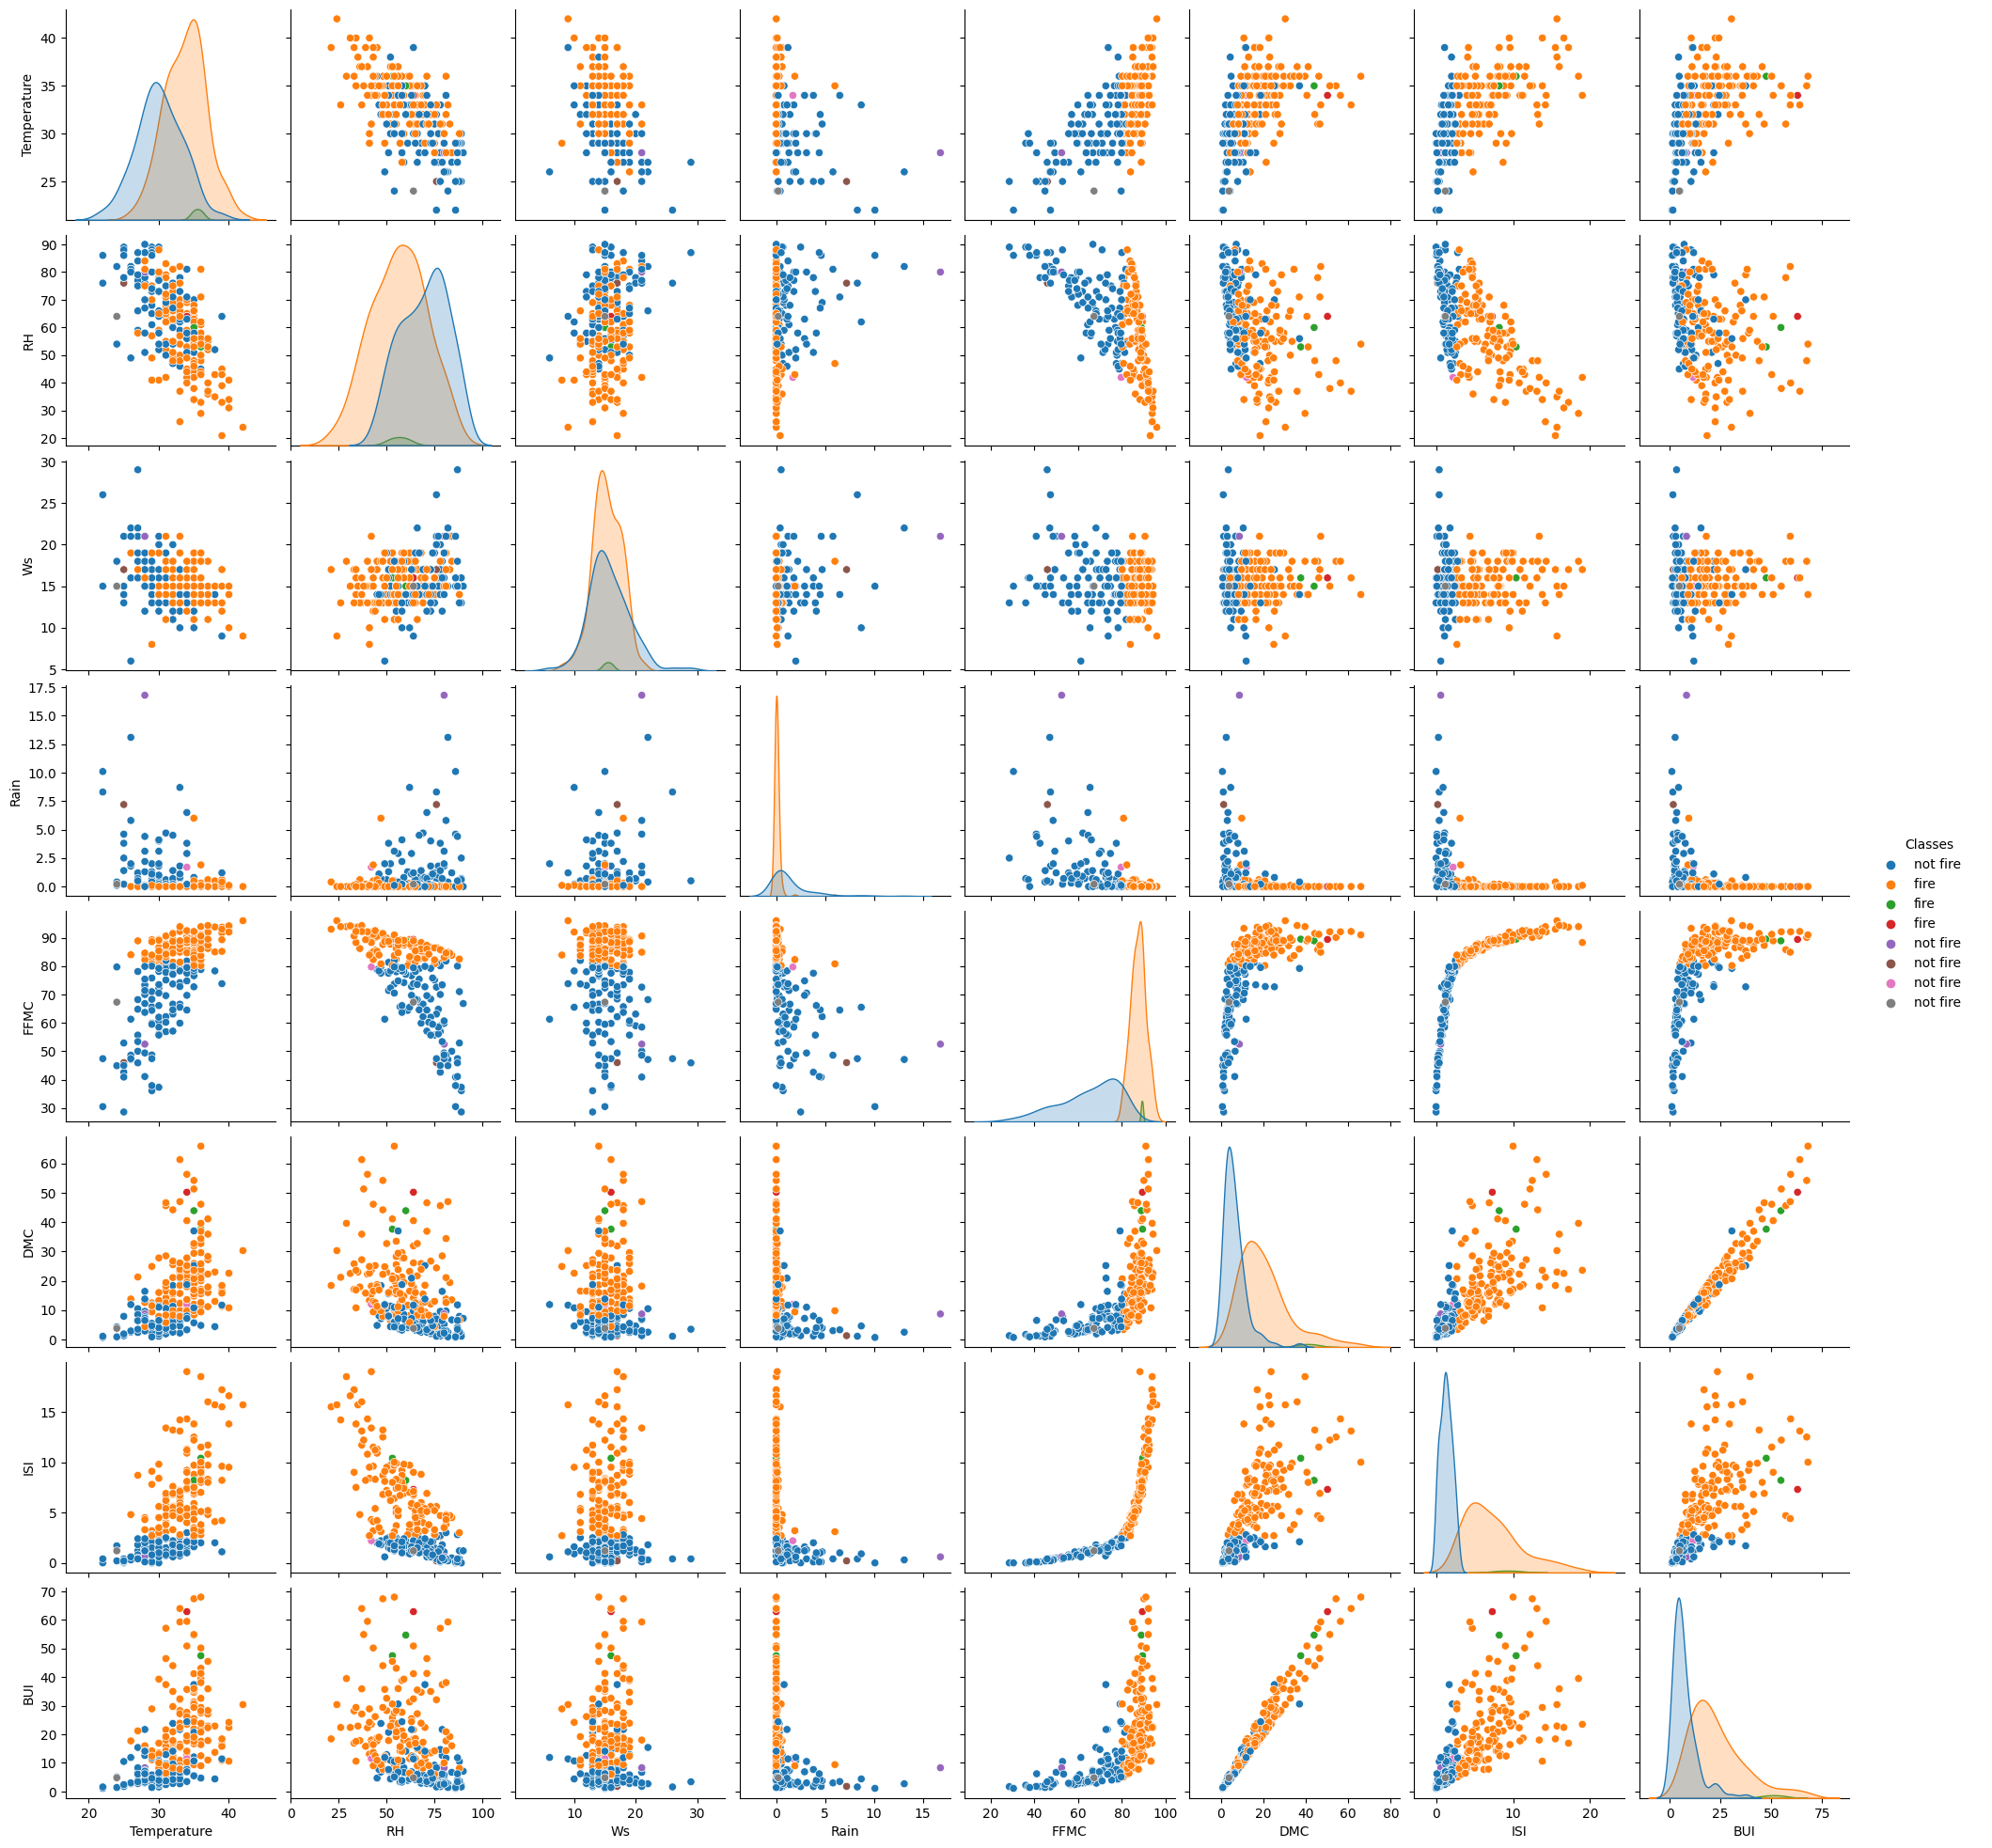

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb 

sb.pairplot(fire_data, hue ='Classes')

From this plot, we can see that there are 8 classes when it should only be 2.

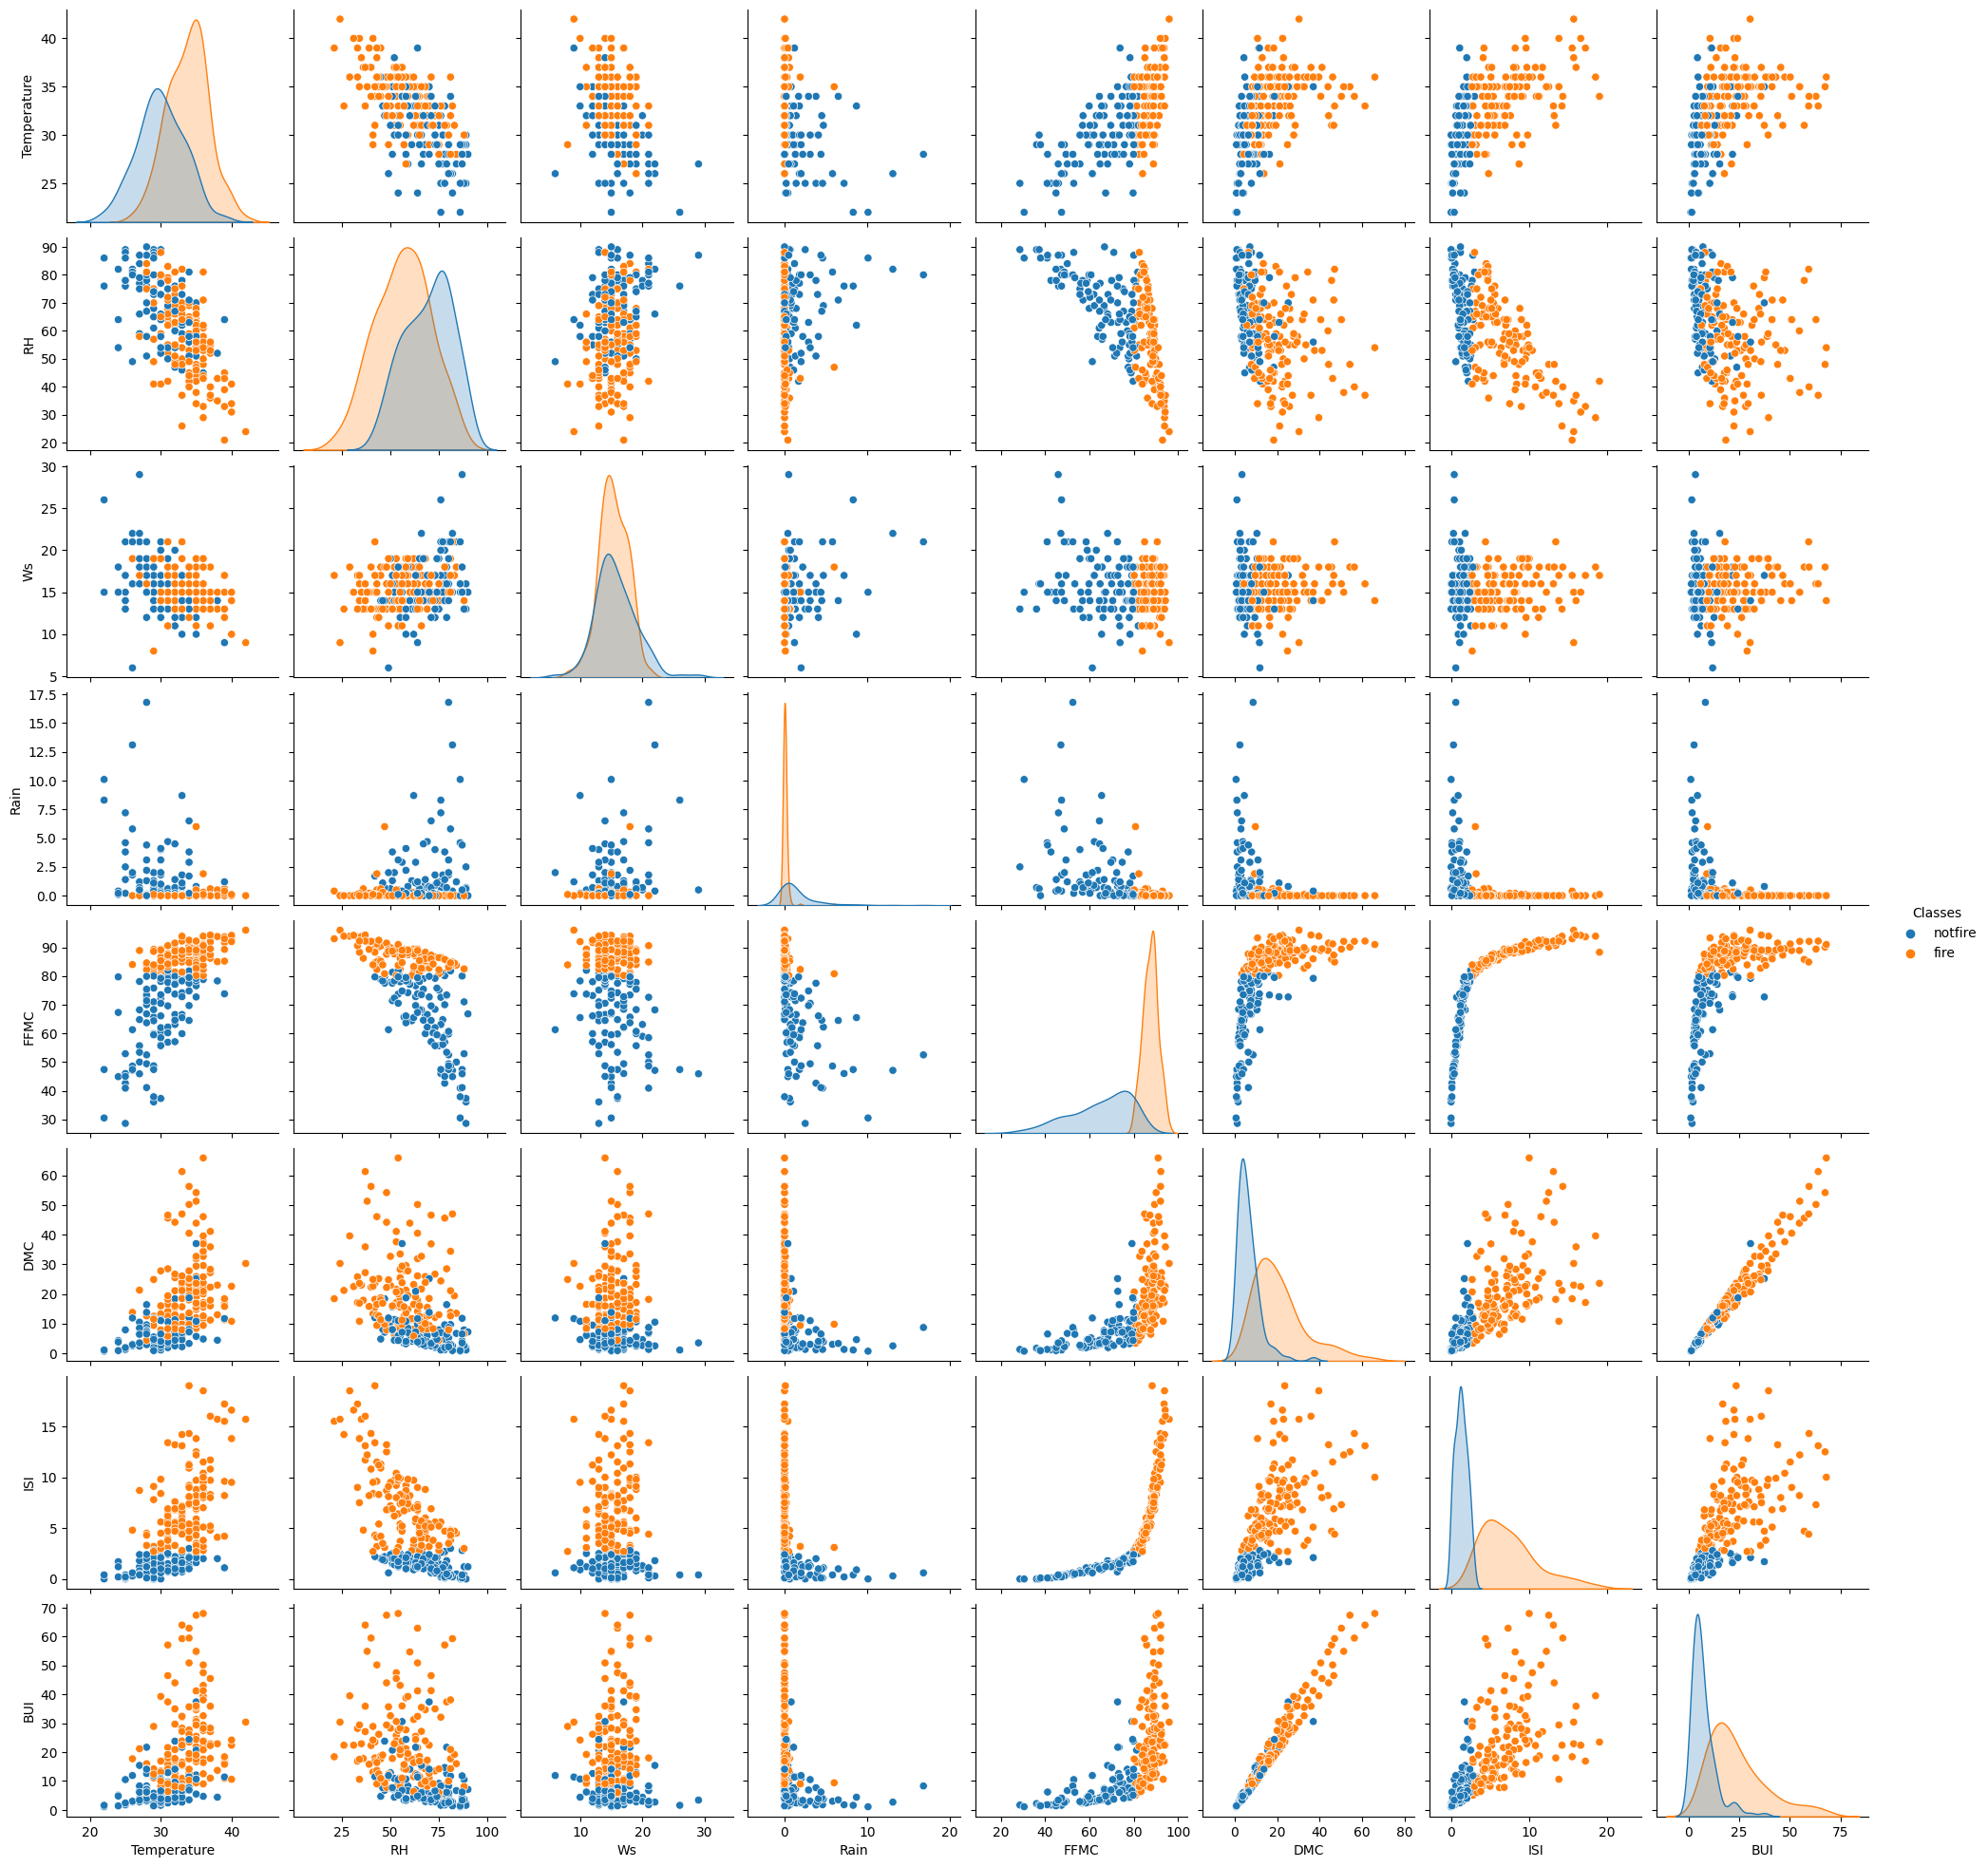

In [8]:
# replace the values of the column Classes remove the whitespaces
fire_data['Classes'] = fire_data['Classes'].str.replace(' ', '')
# now plot again 
sb.pairplot(fire_data, hue ='Classes')

Now that we have 2 classes, we can see that that is a tendency in the FWI components for the fire to occur. There is a clear separation between the two classes, where the left side is the `not fire` class and the right side is the `fire` class.

There are some outliers in the dataset, like the two `Ws` entries around 20-30 and the two `Rain` entries around 10-20, but we will not remove them because they are not errors. They are just extreme values and we think that they are a valuable information for the model.

# Classification

### Workflow
The first step is to understand the problem and identify potential features and label. Features are those characteristics or attributes which affect the results of the label and that help the model to classify the label correctly. The label is the target variable that we want to predict. In our case, the label is the `Classes` column.

The classification has **2 phases**: <u>learning</u> and <u>evalutation</u>. In the learning phase, the classifier trains its model on a given dataset, and in the evaluation phase, it tests the classifier's performance. Performance is measured by various parameters such as accuracy, error, precision, and recall.

## First Classifier: Naive Bayes
The first classifier we will use is based on Bayes Theorem. It is one of the simplest supervised learning algorithms, but it is fast, accurate and realiable. 
Basicaly, it assumes that the effect of a particular feature in a class is independent of other features. For example, a fruit may be considered to be an apple if it is red, round, and about 3 inches in diameter. Even if these features depend on each other or upon the existence of the other features, all of these properties independently contribute to the probability that this fruit is an apple and that is why it is known as ‘Naive’.

### Steps
1. Calculate the prior probability for given class labels
2. Calculate conditional probability for each feature for each class
3. Multiply same class conditional probability
4. Multiply prior probability with the output of previous step
5. Perform this for all the classes, and the class with the highest probability is the outcome of prediction

#### Classifier building in Scikit-learn
Before we start the training process, we need to split the dataset into training and testing for model evaluation.

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

# since we have integers represented as strings, we need to convert them to float in order to use the algortihm
matrix = np.array(fire_data.drop(['Classes','Date'], axis=1).values)
matrix = matrix.astype(float)

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(matrix, fire_data['Classes'].values, test_size=0.33, random_state=125)



#### Model building and training
Let's build a generic Gaussian Naive Bayes and train it on a training dataset.
To visualize the performance of the model, we will use a confusion matrix. It is a table that represents the predicted labels versus the actual labels, showing the number of true positives, true negatives, false positives, and false negatives. It is a good way to evaluate accuracy and identify any misclassifications.

Time spent on training: 0.00177 seconds


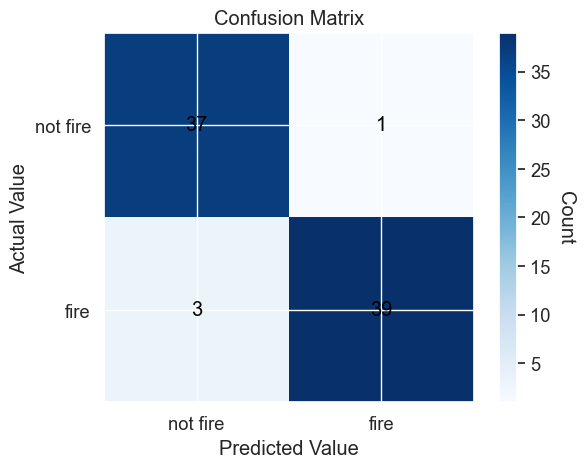

In [93]:
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import time

# Build a Gaussian Naive Bayes classifier
model = GaussianNB()

start_time = time.time()

# Train the model using the training sets
model.fit(X_train, y_train)

training_time = time.time() - start_time
print("Time spent on training: {:.5f} seconds".format(training_time))

# Predict the response for test dataset
predicted = model.predict(X_test)

predicted_np = np.where(predicted == 'notfire', 0, 1) # if predicted == 'not fire' then 0 else 1
actual_values = np.where(y_test == 'notfire', 0, 1) # if y_test == 'not fire' then 0 else 1

cm = confusion_matrix(actual_values, predicted_np)
_, ax = plt.subplots()

im = ax.imshow(cm, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['not fire', 'fire'])
ax.set_yticklabels(['not fire', 'fire'])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual Value')
ax.set_title('Confusion Matrix')

# Add text annotations to the plot
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
            
# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Count', rotation=-90, va='bottom')

# Display the plot
plt.show()




We can see the accuracy values too:

In [11]:
from sklearn.metrics import (accuracy_score, f1_score)

accuray = accuracy_score(predicted, y_test)
f1 = f1_score(predicted, y_test, average='weighted')

print(f'Accuracy: {accuray}')
print(f'F1 Score: {f1}')

Accuracy: 0.95
F1 Score: 0.9499687304565356


## First Classifier: k-nearest neighbour

The k-nearest neighbors (k-NN) algorithm is a simple and intuitive classification algorithm used for both regression and classification tasks. It works based on the principle that data points with similar features tend to belong to the same class or have similar target values. The algorithm classifies or predicts the target value of a new data point based on its proximity to its k nearest neighbors in the training dataset.

Adding necessary imports and preparing Dataset for model training and testing.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Get all inputs (Attributes) and all the labels (Target binary class)
all_inputs = fire_data.drop(['Classes','Date'],axis=1).values
all_labels = fire_data['Classes'].values

# Data split for training and testing (80/20 ratio)
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.20, random_state=1)


### Simple model prediction using an example classifier

To better understand and get an initial idea of the model, let's make a Simple model prediction and evaluate It.

In [13]:
# Create a simple instance of the KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
# Train the classifier on the training set
knn = knn.fit(training_inputs,training_classes)
# Validate the classifier on the testing set using classification accuracy
class_prediction = knn.predict(testing_inputs)
# Calculate accuracy of the model
accuracy = metrics.accuracy_score(testing_classes, class_prediction)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9387755102040817


Cross-validation with StratifiedKFold is a technique that assesses model performance by splitting the data into multiple folds.
The cv parameter determines the number of folds used. It helps detect overfitting as the model's performance is evaluated on different data subsets.

Now Using Cross Validation to access our model.

Text(0.5, 1.0, 'Average score: 0.91283')

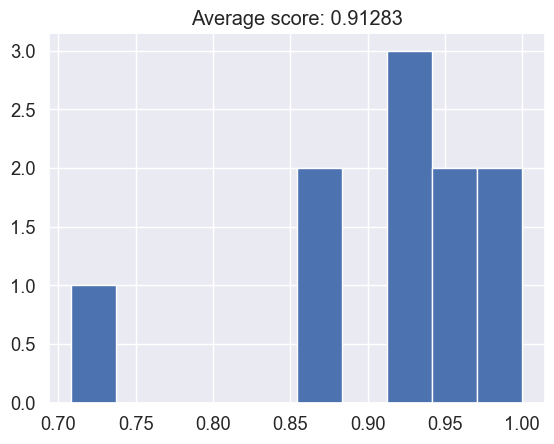

In [90]:
cv_scores = cross_val_score(knn, all_inputs, all_labels , cv=10)
plt.hist(cv_scores)
plt.title('Average score: {:.5f}'.format(np.mean(cv_scores)))

### Grid Search to find the Best Parameters.

Using Grid Search, find the best parameters for the algorithm based on the data.

General k-nearest parameters to be studied:
 - n_neighbors : Number of neighbors to use.
 - weights : Can be:
    - ‘uniform’: All points in each neighborhood are weighted equally
    - ‘distance’: Weight points by the inverse of their distance.
 - p : Power parameter for the Minkowski metric. When:
    - p = 1 : manhattan_distance (l1).
    - p = 2 : euclidean_distance (l2).

In [91]:
# Create a KNN classifier
knn = KNeighborsClassifier()

# Define the parameter grid for GridSearchCV
parameter_grid = {'n_neighbors': list(range(1, len(training_inputs)+1)),
                  'weights': ['uniform', 'distance'],
                   'p' : [1,2] }

# Perform grid search to find the best parameters
grid_search = GridSearchCV(estimator=knn, param_grid=parameter_grid)
grid_search.fit(all_inputs, all_labels)

# Print the best score (Cross-Validation) and best parameters
print('Best score: {:.5f}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.92577
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}


### Final prediction!
Using the best parameters found:
1. Create and Train the model
2. Make the final prediction
3. Calculate statistics like accuracy, precision, recall, f1 score and train/test times
4. Calculate and show the resulting confusion matrix.

Prediction Stats
Accuracy: 0.93878
Precision: 0.93966
Recall: 0.93878
F1 Score: 0.93872
Time spent on training: 0.00200 seconds
Time spent on testing: 0.00203 seconds


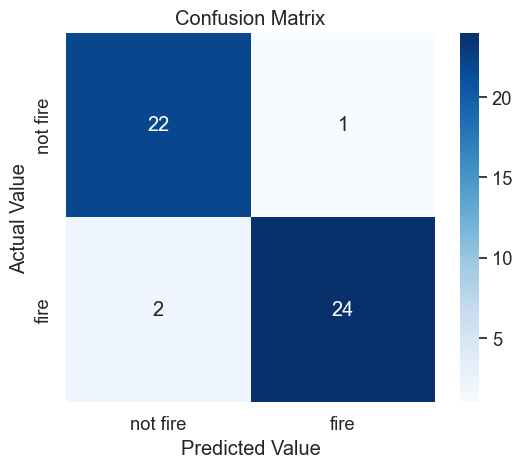

In [86]:
# Create an instance of the KNeighborsClassifier with the best studied parameters
knn = KNeighborsClassifier(**grid_search.best_params_)
# Train the classifier on the training set
start_time = time.time()
knn = knn.fit(training_inputs,training_classes)
training_time = time.time() - start_time

# Validate the classifier on the testing set using classification accuracy
class_prediction = knn.predict(testing_inputs)
testing_time = time.time() - (start_time + training_time)

# Calculate accuracy, precision, recall, f1 score and train/test time of the model
accuracy = metrics.accuracy_score(testing_classes, class_prediction)
precision = metrics.precision_score(testing_classes, class_prediction, average='weighted')
recall = metrics.recall_score(testing_classes, class_prediction, average='weighted')
f1 = metrics.f1_score(class_prediction, testing_classes, average='weighted')
print('Prediction Stats')
print(f'Accuracy: {accuracy:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')
print("Time spent on training: {:.5f} seconds".format(training_time))
print("Time spent on testing: {:.5f} seconds".format(testing_time))

# Calculate confusion matrix of results
confusion_matrix = metrics.confusion_matrix(testing_classes,class_prediction)
# Plot confusion matrix as a heatmap
class_labels = ["not fire", "fire"]
heatmap = sb.heatmap(confusion_matrix, annot=True, cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            linecolor='black', square=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()